# Evaluate the AdaBoost model
We will evaluate the performance of the AdaBoost model with optimized hyperparameters, all four metadata features (virus avidity, antiserum potency, and passage category (egg or cell) of virus isolates and antisera) and best-performing amino acid mutation matrix over 14 test seasons from 2014NH to 2020SH.

## Imports

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
from ast import literal_eval
import random
import gc

# self defined functions and models
import utilities
import model_utilities

# for encoding of metadata information
from sklearn.preprocessing import OneHotEncoder

# for parallel computation
from functools import partial
from joblib import Parallel, delayed

# for reproduciblility, fix the randomly generated numbers
SEED = 100
random.seed(SEED)
np.random.seed(SEED)

## Variables

In [2]:
mut_mat       = 'GIAG010101'   # mutation matrix
Test_Seasons  = [str(year)+s for year in range (2014, 2021) for s in ['NH', 'SH']]   # seasons from 2014NH to 2020SH

HA1_features  = [f"HA1_{x}" for x in range(1,329+1)]
meta_features = [
                 'virus',   # virus avidity (based on both name and passage)
                 'serum',   # antiserum potency (based on both name and passage)
                 'virusPassCat',   # virus passage category
                 'serumPassCat'   # serum passage category
                 ]   # metadata features

metadata   = 'a+p+vPC+sPC'   # label to record which metadata is being used
model_name = 'AdaBoost'   # the type of model to be used

## Paths and filenames

In [3]:
# paths
path_data   = "../data/"   # path of data
path_result = "../results/Fig2_model_evaluation/"   # results will be saved in this directory
Path(path_result).mkdir(parents=True, exist_ok=True)   # make directory if it does not exist already

# filenames
data_fn    = path_data + f"nhts_ha1_{mut_mat}.csv"   # input data
results_fn = path_result + "Fig2_performance_testScores.csv"   # to save performance scores for test dataset
output_fn  = path_result + f"output_testSeasons_{mut_mat}.csv"   # to save virus-antiserum info., actual and predicted NHTs

# filenames for figures are mentioned within the codes for figures

## Read data
- The format of the data file is defined in notebook [SuppFig2a_seasonal_data_distribution](SuppFig2a_seasonal_data_distribution.ipynb)
- Genetic difference (seq_diff) encoded as per the mutation matrix
- Converter is used to load the genetic difference saved as a list of floats

In [4]:
data = pd.read_csv(data_fn, converters={'seq_diff': literal_eval})

## Function to compute performance of model for a given season
- Split the data into training and test datasets
- Prepare encoded inputs (genetic difference and metadata features)
- Train and evaluate the model
- Compute predictive performance

> **Parameters**
> - season (str): identifier for the Northern or Southern Hemisphere season such as "2015NH"

> **Returns**
> - season (str): identifier for the Northern or Southern Hemisphere season such as "2015NH"
> - (numpy array): actual NHTs for the given season
> - (numpy array): predicted NHTs for the given season
> - (DataFrame): info. of each virus-antiserum pair 

In [ ]:
def train_test_season(season):
    '''
    Train Test Split
        - based on seasonal framework
        - Train: past virus isolates paired with past sera
        - Test: circulating virus isolates paired with past sera
    '''
    ind_train, ind_test = utilities.seasonal_trainTestSplit(data[['virus', 'serum', 'virusDate', 'serumDate']], season)
    
    # training dataset
    data_train = data.iloc[ind_train].copy()
    data_train.reset_index(drop=True, inplace=True)
    
    # test dataset
    data_test = data.iloc[ind_test].copy()
    data_test.reset_index(drop=True, inplace=True)


    '''
    Input features (genetic difference)
    '''
    # training dataset
    X_train = pd.DataFrame(data_train.seq_diff.to_list(),
                           index=data_train.index,
                           columns=HA1_features)
    X_train.fillna(0, inplace=True)   # replace nan with 0
    
    # test dataset
    X_test = pd.DataFrame(data_test.seq_diff.to_list(),
                          index=data_test.index,
                          columns=HA1_features)
    X_test.fillna(0, inplace=True)   # replace nan with 0
    
    
    '''
    Input features (metadata features)
    '''
    X_train_meta = data_train[meta_features].fillna('None').astype('str')
    X_test_meta  = data_test[meta_features].fillna('None').astype('str')
    
    
    # one hot encoding
    ohe = OneHotEncoder(handle_unknown='ignore')
    X_train_meta = ohe.fit_transform(X_train_meta).toarray()
    X_test_meta  = ohe.transform(X_test_meta).toarray()
      
    X_train = np.hstack((X_train.values, X_train_meta))
    X_test  = np.hstack((X_test.values, X_test_meta))


    del X_train_meta, X_test_meta
    gc.collect()
        
    
    '''
    Training and testing
    '''
    model = getattr(model_utilities, f"model_{model_name}")
    results = model(X_train,
                    data_train.nht.values,
                    X_test = X_test)
    
    
    '''
    Test Scores
    '''
    cols       = ['mut_mat', 'model', 'metadata', 'season']
    col_values = [mut_mat, model_name, metadata, season]
    utilities.compute_scores(data_test.nht.values, results['pred_test'], results_fn, col=cols, col_val=col_values)
    
    
    '''
    Save data info. and output
    '''
    output_tmp = data_test[['virus', 'virusPassCat', 'virusDate',
                            'serum', 'serumPassCat', 'serumDate',
                            'nht']].copy()
    output_tmp.loc[:, 'predict']      = results['pred_test']
    output_tmp.loc[:, 'variant']      = data_test['variant'].values
    output_tmp.loc[:, 'pred_variant'] = (results['pred_test'] > 2) * 1
    output_tmp.loc[:, 'season']       = season
    
    
    return season, data_test.nht.values, results['pred_test'], output_tmp

## Average performance of the model
- For each test season from 2014NH to 2020SH
    - Train and evaluate the model using above-given function
    - Save the predictions
- Compute average predictive performance

In [5]:
# train test for each test season in parallel
result = Parallel(n_jobs=-1, verbose=1)(delayed(train_test_season)(test_season) for test_season in Test_Seasons)

# get results
seasons, actual_all, predict_all, output_all = zip(*result)

'''
Micro-average over seasons
'''
actual  = np.concatenate(actual_all)
predict = np.concatenate(predict_all)

# Test scores
cols       = ['mut_mat', 'model', 'metadata', 'season']
col_values = [mut_mat, model_name, metadata, 'Average']
utilities.compute_scores(actual, predict, results_fn, col=cols, col_val=col_values)

'''
Save output
'''
output = pd.concat(output_all, ignore_index=True)
output.to_csv(output_fn, index=False)

print("Training and testing completed")

Test Season:  2014NH
Time for training: 27.323559522628784
Test Season:  2014SH
Time for training: 40.67445421218872
Test Season:  2015NH
Time for training: 56.51232957839966
Test Season:  2015SH
Time for training: 73.8529839515686
Test Season:  2016NH
Time for training: 82.73238348960876
Test Season:  2016SH
Time for training: 88.88433361053467
Test Season:  2017NH
Time for training: 98.89306640625
Test Season:  2017SH
Time for training: 133.646582365036
Test Season:  2018NH
Time for training: 144.6876528263092
Test Season:  2018SH
Time for training: 157.97803688049316
Test Season:  2019NH
Time for training: 163.50231409072876
Test Season:  2019SH
Time for training: 184.52326703071594
Test Season:  2020NH
Time for training: 205.00826740264893
Test Season:  2020SH
Time for training: 240.53920984268188
Training and testing completed


## Imports and configurations for plotting

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set_context(rc={'axes.labelsize':9,
                    'xtick.labelsize':8,
                    'ytick.labelsize':8,
                    'legend.fontsize':8,
                    'legend.title_fontsize':8})

## Read test scores and prepare data for plots

In [5]:
# selected metrics for plotting
metrics = ['MAE', 'AUROC']

# read test scores
scores = pd.read_csv(results_fn)

# keep season indicator and performance scores based on selected metrics
scores = scores[['season']+metrics]


'''
for heatmap change to matrix form
'''
# set season as index
df = scores.set_index('season')

# transpose index and columns
df = df.transpose()

## Plot MAE per season

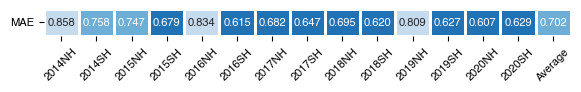

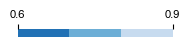

In [13]:
fig, ax = plt.subplots(figsize=(6.8,0.35))
fig_cbar, ax_cbar = plt.subplots(figsize=(2,0.1))   # separate figure for colorbar

tmp = sns.heatmap(df[df.index == 'MAE'],
                  annot=True, annot_kws={'size':8}, fmt='.3f',
                  vmin=0.6,
                  vmax=0.9,
                  cmap=sns.color_palette('Blues_r', 3),
                  cbar_ax=ax_cbar,
                  cbar_kws={'shrink':0.85, 'orientation':'horizontal'},
                  linewidths=1,
                  # square=True,
                  ax=ax)

# configurations for figure
tmp.set_xticklabels(tmp.get_xticklabels(), rotation=45)
cbar = tmp.collections[0].colorbar
cbar.ax.tick_params(labelsize=8)
cbar.ax.set_xticks([cbar.ax.get_xticks()[0], cbar.ax.get_xticks()[-1]])
cbar.ax.xaxis.set_ticks_position('top')
ax.set_yticklabels(ax.get_yticklabels(), rotation = 0)
ax.set_xlabel("")
ax.set_ylabel("")

# save figure
fig_fn = path_result+"Fig2_testScores_MAE_heatmap.svg"
fig.savefig(fig_fn, format='svg', bbox_inches='tight')

# save figure for colorbar
fig_cbar_fn = path_result+"Fig2_testScores_MAE_heatmap_colorbar.svg"
fig_cbar.savefig(fig_cbar_fn, format='svg', bbox_inches='tight')

## Plot AUROC per season

In [6]:
fig, ax = plt.subplots(figsize=(6.8,0.35))
fig_cbar, ax_cbar = plt.subplots(figsize=(2,0.1))

tmp = sns.heatmap(df[df.index == 'AUROC'],
                  annot=True, annot_kws={'size':8}, fmt='.2f',
                  vmin=0.8,
                  vmax=1,
                  cmap=sns.light_palette('seagreen', 4),
                  cbar_ax=ax_cbar,
                  cbar_kws={'shrink':0.85, 'orientation':'horizontal'},
                  linewidths=1,
                  # square=True,
                  ax=ax)

# configurations for figure
tmp.set_xticklabels(tmp.get_xticklabels(), rotation=45)
cbar = tmp.collections[0].colorbar
cbar.ax.tick_params(labelsize=8) 
cbar.ax.set_xticks([cbar.ax.get_xticks()[0], cbar.ax.get_xticks()[-1]])
cbar.ax.xaxis.set_ticks_position('top')
ax.set_yticklabels(ax.get_yticklabels(), rotation = 0)
ax.set_xlabel('')
ax.set_ylabel('')

# save figure
fig_fn = path_result+"Fig2_testScores_AUROC.svg"
fig.savefig(fig_fn, format='svg', bbox_inches='tight')

# save figure for colorbar
fig_cbar_fn = path_result+"Fig2_testScores_AUROC_colorbar.svg"
fig_cbar.savefig(fig_cbar_fn, format='svg', bbox_inches='tight')